# Rojové algoritmy

Na dnešním cvičení se podíváme na další druhy přírodou inspirovaných algoritmů, které se používají pro optimalizační úlohy. Konkrétně to bude algoritmus na optimalizaci pomocí hejna částic a optimalizaci mravenčí kolonií. Oba algoritmy jsou relativně jednoduché na implementaci, a proto je napíšeme sami.

## Optimalizace hejnem částic

Optimalizace hejnem částic je optimalizační algoritmus inspirovaný chováním hejn ryb nebo ptáků při hledání potravy, který se používá pro spojitou optimalizaci. Jedinec, typicky vektor R čísel, se nazývá částice a pohybuje se v hejnu prostorem parametrů. Každá částice je reprezentovaná pomocí 2 vektorů, které určují její pozici a rychlost. Navíc si pamatuje pozici v prostoru, kde měla nejlepší fitness a celé hejno si pamatuje pozici, kde měla nějaká částice nejlepší globální fitness. 

Algoritmus je pak velice jednoduchý -- každá částice se pohybuje v prostoru a je přitahovaná k místu se svým nejlepším řešením a k místu globálního nejlepšího řešení. Na začátku se inicializuje každé částici pozice a rychlost náhodně. Pak se pro každou částici spočítá její fitness, updatuje se dosavadní nejlepší pozice jedince a globální nejlepší pozice v hejnu. Nakonec se spočítá nová rychlost a pozice jedince z původní pozice a rychlosti, jejího nejlepšího místa a globálního nejlepšího místa v hejnu. Toto se opakuje dokud není splněno nějaké ukončovací kritérium, například počet iterací.


Zkusíme se tedy podívat na algoritmus optimalizace hejnem částic (v angličtině particle swarm optimalization (PSO)). Implementace je snadná, protože de facto stačí jenom opsat rovnice.

In [1]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

Začneme tím, že si definujeme třídu pro částici, která je definovaná svou pozicí a rychlostí. Zároveň si pamatuje svou nejlepší pozici v historii. Zároveň definujeme i metodu, aby se jedinec uměl sám vypsat.

In [2]:
class Particle:
    def __init__(self, position, speed):
        self.position = position
        self.speed = speed
        self.best_position = position
            
    def __print__(self):
        return str(self.position) + ', ' + str(self.speed) + ', ' + str(self.best_position)

Na začátku algoritmu budeme potřebovat umět nainicializovat hejno. To uděláme tak, že každé částici zvolíme náhodnou počáteční pozici a rychlost. Rychlosti se typicky nastavují menší. 

In [3]:
def init_swarm(size, dimension):
    swarm = []
    for _ in range(size):
        swarm.append(Particle(position = np.random.uniform(size=(1,dimension)), 
                              speed = 0.2*np.random.uniform(size=(1,dimension)) - 0.1))
    return swarm

Dále budeme potřebovat funkci na aktualizaci pozic a rychlostí všech částic v hejnu podle rovnic.

In [4]:
def update_swarm(swarm, fit, best_global, phi1=1, phi2=0.5, omega=0.95):
    for particle in swarm:
        particle.speed = omega*particle.speed + phi1*(particle.best_position - particle.position) + phi2*(best_global - particle.position)
        particle.position = particle.position + particle.speed
        
        if fit(particle.position) < fit(particle.best_position):
            particle.best_position=particle.position
    return swarm

Také bude potřeba funkce na update nejlepšího globálního řešení. K tomu si definujeme fitness funkci, která bude jen hodnota rastrigin funkce v daném bodě.

In [5]:
def compute_best_global_position(swarm, fit):
    return min(swarm, key=lambda x: fit(x.best_position)).best_position

# fitness funkce
def fitness(position):
    position = position[0]
    N = len(position)
    A = 10
    value = A*N
    for i in range(0,len(position)):
        value += position[i]**2 - A*math.cos(2*math.pi*position[i])
    return value, 

Nyní už máme všechny funkce, takže si už můžeme definovat hlavní kód algoritmu optimalizace hejnem částic.

In [6]:
def pso(fitness, swarm_size, problem_dim, max_iters):
    swarm = init_swarm(size=swarm_size, dimension=problem_dim)
    best_global_position = compute_best_global_position(swarm, fitness)
    best_fitness = []
    for iteration in range(max_iters):
        swarm = update_swarm(swarm, fitness, best_global_position)
        best_global_position = compute_best_global_position(swarm, fitness)
        print(f'{iteration:4}: {fitness(best_global_position)[0]:.4f}')
        best_fitness.append(fitness(best_global_position)[0])
    return best_global_position, best_fitness

Když máme napsaný celý algoritmus, můžeme ho zkusit otestovat například na problému [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function), který jsme řešili na cvičení s evolučními algoritmy. O této funkci jsme si říkali, že je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Navíc nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. Minimum funkce je v bodě 0 s hodnotou 0.

   0: 2.2532
   1: 2.2532
   2: 2.2532
   3: 2.2532
   4: 2.1768
   5: 2.1768
   6: 2.1768
   7: 2.1482
   8: 2.0282
   9: 2.0282
  10: 2.0282
  11: 2.0282
  12: 2.0282
  13: 2.0238
  14: 2.0040
  15: 1.9983
  16: 1.9983
  17: 1.9983
  18: 1.9983
  19: 1.9910
  20: 1.9910
  21: 1.9910
  22: 1.9905
  23: 1.9904
  24: 1.9904
  25: 1.9904
  26: 1.9904
  27: 1.9904
  28: 1.9904
  29: 1.9903
best position
[[ 9.95101257e-01  9.95486191e-01 -1.27616463e-03 -4.97684573e-04]]


Text(0.5, 0, 'Generace')

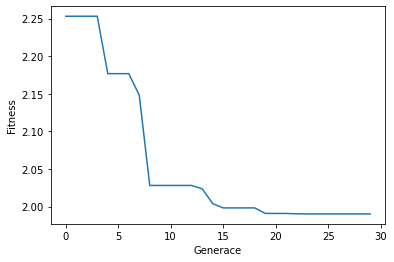

In [7]:
best_position, best_fitness = pso(fitness, swarm_size=1000, problem_dim=4, max_iters=30)
print('best position')
print(best_position)

plt.plot(best_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

Zde si můžeme zkusit měnit dimenzi problému a pozorovat, že pro rostoucí dimenzi je třeba zvětšovat velikost hejna, aby se algoritmus nezasekl v lokálním optimu a že na počtu generací to až zas tolik nezáleží, protože algoritmus brzy zkonverguje do nějakého optima a tam už zůstane.

## Optimalizace mravenčí kolonií

Optimalizace mravenčí kolonií (Ant Colony Optimization (ACO)) je algoritmus inspirovaný chováním mravenců při hledání potravy, který se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na problém hledání cest v grafu. 

Mravenci se pohybují v prostředí a zanechávají za sebou feromonouvou stopu, která časem slábne a díky které spolu komunikují a slouží jim jako pozitivní druh zpětné vazby. Mravenec začne v náhodném bodě a rozhoduje se kam půjde dál. Nejprve se pohybují náhodně kolem mraveniště. Jakmile naleznou potravu, vrací se stejnou cestou, kterou k potravě došli a zanechávají za sebou feromonovou stopu. Jakmile nějkaý další mravenec narazí na feromonovou stopu, s větší pravděpodobností se po ní vydá spíše, než aby dále prozkoumával prostředí. Čím více mravenců se pohybuje mezi zdrojem potravy a mraveništěm, tím silnější je stopa a šance, že cesta přitáhne další mravence. Navíc na kratší cestě feromon vyprchává pomaleji, takže bude silnější a bude přitahovat více mravenců.

Zkusíme si s jeho pomocí vyřešit [Problém obchodního cestujícího](https://en.wikipedia.org/wiki/Travelling_salesman_problem), který se dá převést na problém hledání nejkratší Hamiltonovské kružnice v úplném grafu. Hamiltonovská kružnice v grafu je kružnice, která prochází všemi vrchloly. Implementace už je zde trochu složitější, ale pořád celkem rozumná.

Nejprve si vytvoříme kolekci ```namedtuple```, do které si uložíme informace o vrcholu, tedy jeho souřadnice a název. Je vhodnější než normální třída, protože je to rychlejší struktura. 

In [8]:
Vertex = namedtuple('Vertex', ['name', 'x', 'y'])

Dále budeme potřebovat funkci, co nám spočítá vzdálenost dvou bodů. To uděláme chytře a použijeme k tomu lru (least recently used) cache, která si pamatuje si vyhodnocené funkce a při jejich opakovaném volání se stejnými parametry se nemusí znovu vyhodnocovat.

In [9]:
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

Dále se bude hodit fitness funkce, která jen vyhodnotí danou cestu mezi městy tak, ze bere dvojice po sobě jdoucích vrcholů v řešení a sčítá vzdálenosti měst.

In [10]:
def fitness(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:]):
        solution_distance += distance(vertices[x], vertices[y])
    solution_distance += distance(vertices[solution[-1]], vertices[solution[0]])
    return solution_distance

Samotný algoritmus bude ještě potřebovat funkci na počáteční inicializaci feromonu, která by sice měla být stopa všude nulová, ale protože s ní pracujeme jako s pravděpodobností, tak by to nefungovalo, tak ji nastavíme na nějakou malou hodnotu. Také bude potřeba dělat update feromonu a to tak, že na všechny hrany v cestě rozpočítáme rovnoměrně tu fitness, která říká, jak byla váha dobrá. A protože délku chceme minimalizovat, takže použijeme inverzní Q/fit, kde Q bude nějaká konstanta.

In [11]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

Ještě nám zbývá pomocná funkce, kde mravenec generuje řešení, tedy náhodně prochází města, dokud neobejde všechny. Pak už můžeme napsat hlavní funkci algoritmu, kde se vytváří řešení, a podle jejich kvality se upravuje feromon na hranách. Zároveň si pamatujeme nejlepší řešení, abychom ho na konci mohli vrátit.

In [12]:
def generate_solutions(vertices, pheromones, distance, N, alpha=1, beta=3):
    
    # pravdepodobnost vyberu dalsiho mesta
    def compute_prob(v1, v2):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001

    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        available = list(range(pheromones_shape))
        solution = [np.random.randint(0, pheromones_shape)]
        available.remove(solution[0])
        while available:
            probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
            solution.append(selected)
            available.remove(selected)
        yield solution


Nyní už si můžeme vytvořit hlavní kód ACO.

In [13]:
def ant_solver(vertices, distance, ants=10, max_iterations=3000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(vertices, pheromones, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x), solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_solution, pheromones

Zkusíme si nyní algoritmus otestovat na hlavních evropských městech, vstupní data jsou uložena v souboru *cities.csv*.

In [14]:
vertices = []
with open('cities.csv') as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

pprint.pprint(vertices)

best_solution, pheromones = ant_solver(vertices, distance)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

 170, 262.7443, 279.6756, 313.3659
 171, 267.5725, 281.1447, 324.4076
 172, 267.5725, 284.9938, 320.0192
 173, 258.6477, 290.1837, 368.1813
 174, 241.1550, 286.1613, 305.9505
 175, 246.5699, 283.1442, 303.4331
 176, 265.3155, 285.8223, 339.2112
 177, 266.8923, 289.7873, 322.8642
 178, 278.5669, 294.6770, 347.6403
 179, 260.6414, 289.3419, 317.6556
 180, 273.0314, 289.0002, 318.1745
 181, 265.6732, 289.1354, 331.5986
 182, 269.6333, 297.8014, 321.0125
 183, 269.6333, 286.1092, 308.9192
 184, 251.0918, 286.2816, 313.9689
 185, 258.6150, 288.1628, 332.1091
 186, 260.3524, 283.1926, 320.8621
 187, 260.5713, 280.4226, 307.7608
 188, 273.4855, 298.9178, 336.5684
 189, 274.6688, 295.0765, 339.3285
 190, 264.0946, 292.4281, 344.5438
 191, 263.8356, 282.7803, 303.2131
 192, 268.5445, 292.8017, 326.1743
 193, 269.3358, 291.3678, 323.8478
 194, 268.8978, 283.0241, 305.3556
 195, 264.3014, 283.2053, 310.8380
 196, 266.4831, 291.7645, 328.3092
 197, 259.7340, 286.7698, 320.2084
 198, 259.7340, 287.

 406, 262.0208, 284.1443, 321.7516
 407, 255.2156, 280.6522, 318.2070
 408, 255.2156, 277.7856, 315.6826
 409, 272.1214, 285.2180, 320.5392
 410, 266.2383, 277.3690, 298.6793
 411, 261.4985, 272.0209, 298.2729
 412, 256.7658, 282.7896, 302.0411
 413, 251.0983, 287.4926, 321.2889
 414, 251.4514, 275.3650, 293.0571
 415, 259.3567, 286.3114, 318.5305
 416, 251.2865, 279.8516, 310.9663
 417, 267.5257, 285.2176, 317.7631
 418, 254.9136, 280.9188, 320.4411
 419, 263.0421, 292.8520, 333.2917
 420, 268.1558, 286.4191, 312.1746
 421, 259.2770, 285.2456, 325.6481
 422, 265.4368, 288.9209, 307.5107
 423, 264.9370, 293.3074, 327.4414
 424, 264.7507, 287.2021, 322.2261
 425, 270.6906, 296.2850, 333.3767
 426, 257.4471, 280.2997, 312.0284
 427, 275.7214, 292.8431, 328.6505
 428, 253.8627, 283.6448, 326.1540
 429, 259.8429, 280.3958, 307.0842
 430, 267.1057, 291.9431, 334.2954
 431, 273.9729, 299.3373, 317.6920
 432, 273.1261, 291.1504, 328.0019
 433, 270.2078, 308.9266, 342.6593
 434, 272.9699, 292.

 647, 272.2674, 291.4121, 331.5547
 648, 268.3866, 293.1247, 310.2288
 649, 254.8534, 285.2867, 319.1032
 650, 258.9592, 286.3200, 312.7894
 651, 276.0684, 288.8601, 333.3616
 652, 272.6804, 287.3488, 318.8579
 653, 274.9840, 296.3377, 345.3867
 654, 265.3060, 288.1279, 317.5972
 655, 257.7456, 279.7183, 316.4905
 656, 242.3526, 282.6849, 309.6189
 657, 259.1772, 274.3423, 288.7523
 658, 274.8070, 285.0196, 311.3819
 659, 273.0985, 288.3827, 316.8457
 660, 269.1440, 294.6292, 319.6663
 661, 266.8471, 283.2419, 318.2849
 662, 265.4167, 298.9335, 334.8645
 663, 257.7456, 293.0682, 346.9240
 664, 252.5603, 288.5784, 309.3212
 665, 265.3776, 292.5198, 334.8200
 666, 265.5639, 281.8094, 307.7509
 667, 266.7658, 281.7281, 300.0435
 668, 266.6618, 290.6711, 338.9294
 669, 264.6945, 282.0698, 298.1798
 670, 266.2298, 290.9865, 322.1112
 671, 269.1825, 293.2969, 328.1403
 672, 264.1369, 289.7816, 323.3807
 673, 270.4090, 296.9176, 322.0371
 674, 253.1399, 290.6305, 326.9134
 675, 260.0383, 285.

 882, 260.0383, 275.7916, 287.3700
 883, 253.3669, 286.7403, 335.9667
 884, 265.3333, 285.7030, 312.4539
 885, 266.2377, 291.2817, 320.2664
 886, 264.1799, 281.2233, 336.8057
 887, 270.2387, 288.0255, 314.7193
 888, 250.1562, 282.6338, 325.7943
 889, 255.5810, 277.8866, 305.4147
 890, 250.1562, 274.8782, 309.9586
 891, 258.9262, 274.6790, 286.8528
 892, 264.7161, 282.7788, 305.2144
 893, 267.8495, 287.7154, 335.7304
 894, 253.3669, 276.8646, 315.4728
 895, 260.3961, 281.0003, 304.0988
 896, 247.3059, 284.6103, 335.6661
 897, 256.2760, 286.6825, 333.8787
 898, 249.3564, 282.8762, 314.6867
 899, 252.8869, 288.0685, 320.0904
 900, 245.8922, 286.8175, 345.9785
 901, 235.9890, 271.2068, 303.2120
 902, 256.2167, 280.9654, 311.1940
 903, 265.0904, 288.0900, 333.3274
 904, 264.3945, 300.8737, 360.3031
 905, 253.2362, 287.8969, 333.5186
 906, 254.2990, 283.7295, 329.8981
 907, 267.2941, 282.3886, 298.4364
 908, 265.9291, 295.2719, 360.3184
 909, 251.1529, 272.1483, 297.7230
 910, 253.7487, 280.

1118, 265.2304, 288.0431, 305.4322
1119, 257.0917, 286.0209, 329.2126
1120, 269.7268, 296.3087, 335.3623
1121, 265.9477, 290.6231, 338.5098
1122, 264.2015, 289.8786, 326.6055
1123, 261.5485, 282.9011, 316.1444
1124, 265.9477, 280.2387, 291.6263
1125, 257.6335, 294.6477, 334.1556
1126, 257.1282, 284.5203, 313.2617
1127, 261.5984, 279.9573, 296.4479
1128, 258.5322, 288.5613, 382.8484
1129, 245.9521, 263.5864, 277.4233
1130, 257.4819, 279.2950, 324.0969
1131, 237.7963, 279.5846, 324.0644
1132, 254.6553, 284.6811, 307.9926
1133, 251.9478, 287.0834, 364.4169
1134, 251.9478, 284.0664, 324.2241
1135, 256.3384, 275.9314, 323.2733
1136, 259.4556, 282.8018, 309.5170
1137, 265.3768, 290.1109, 306.7787
1138, 255.1550, 293.1843, 341.2970
1139, 255.8074, 299.8992, 342.5659
1140, 260.9004, 294.3382, 335.0518
1141, 260.3094, 283.5135, 321.3826
1142, 260.3094, 282.5655, 315.0847
1143, 253.5502, 284.8358, 315.5469
1144, 266.5745, 287.8788, 323.7162
1145, 244.8138, 278.4066, 322.1565
1146, 257.3776, 279.

1354, 276.3435, 306.2107, 327.4073
1355, 269.3015, 306.2083, 327.4957
1356, 266.9367, 300.6956, 345.4237
1357, 273.4638, 306.2165, 343.8113
1358, 253.1363, 294.0517, 323.8024
1359, 280.5472, 305.8561, 328.1151
1360, 280.1872, 305.0393, 334.1667
1361, 258.3998, 292.3852, 328.3566
1362, 258.5550, 295.9109, 327.1299
1363, 258.9657, 286.1230, 299.8630
1364, 258.7758, 287.0865, 374.3929
1365, 258.3290, 304.6385, 347.9806
1366, 248.3442, 292.1585, 352.7958
1367, 248.3442, 289.4139, 361.7139
1368, 240.0259, 278.6654, 316.5821
1369, 259.0447, 286.4118, 334.1773
1370, 258.3998, 295.0215, 343.6130
1371, 259.2959, 291.2467, 318.2778
1372, 258.4193, 287.3673, 323.7951
1373, 253.0535, 304.4336, 360.8840
1374, 257.4255, 287.2288, 324.7605
1375, 264.3084, 296.7431, 344.6758
1376, 258.0839, 289.5953, 329.1093
1377, 258.6634, 293.1993, 343.0455
1378, 248.3442, 272.2598, 299.8065
1379, 258.4949, 275.3440, 301.2791
1380, 259.2959, 285.3235, 318.6610
1381, 253.9249, 283.3272, 316.1652
1382, 249.3756, 287.

1591, 268.1836, 302.2245, 342.2311
1592, 275.7796, 308.6897, 346.6673
1593, 271.5348, 294.6829, 310.7750
1594, 270.5172, 303.0606, 351.0735
1595, 272.3402, 303.1045, 329.1679
1596, 271.8586, 293.1338, 321.5167
1597, 282.3943, 307.0415, 343.1821
1598, 281.5190, 306.4022, 331.3874
1599, 271.8586, 297.4756, 321.1035
1600, 285.5686, 307.5277, 331.3874
1601, 281.4756, 307.6707, 331.7298
1602, 272.8251, 296.5706, 321.2593
1603, 250.8356, 295.6280, 342.9780
1604, 252.6419, 302.1124, 375.0071
1605, 294.7405, 314.8791, 362.2721
1606, 271.9478, 300.8830, 326.8996
1607, 258.1981, 297.6002, 324.6332
1608, 254.2672, 298.9993, 331.9274
1609, 269.2173, 306.6042, 346.4266
1610, 270.1177, 294.5623, 334.6177
1611, 275.0991, 294.0710, 315.8399
1612, 270.2636, 291.9571, 324.7938
1613, 269.7496, 310.2995, 343.8031
1614, 269.4262, 305.2021, 358.8633
1615, 281.2706, 312.6862, 369.9248
1616, 278.5037, 304.7872, 318.2773
1617, 268.0538, 307.1922, 337.6167
1618, 273.4871, 296.7862, 320.3014
1619, 277.9426, 296.

1830, 245.7748, 286.1221, 344.5126
1831, 247.5064, 280.8121, 302.2582
1832, 246.7920, 292.9677, 330.0161
1833, 249.8435, 291.6777, 347.7096
1834, 251.9399, 290.4377, 339.7379
1835, 247.1011, 299.4190, 322.6395
1836, 241.7067, 288.3346, 317.6143
1837, 242.2135, 279.6813, 328.8842
1838, 258.7067, 289.4558, 332.4221
1839, 242.2135, 275.5901, 321.1625
1840, 250.8561, 278.1142, 301.5898
1841, 249.2316, 266.8946, 286.2063
1842, 245.8796, 270.3180, 308.4883
1843, 246.4002, 274.9740, 327.4425
1844, 256.9108, 276.1152, 297.2898
1845, 239.2850, 271.2130, 324.4021
1846, 243.7885, 275.7266, 316.8354
1847, 247.3191, 276.6404, 323.3667
1848, 255.1872, 284.4142, 308.8585
1849, 253.3724, 295.9886, 350.6294
1850, 245.2737, 267.9007, 299.0795
1851, 239.7595, 266.2377, 325.4043
1852, 239.7595, 266.3957, 288.7906
1853, 244.4142, 260.9851, 299.8010
1854, 240.1995, 266.0225, 313.2720
1855, 251.4804, 273.0416, 306.7563
1856, 235.6907, 269.8836, 325.5325
1857, 241.6299, 265.9413, 313.2812
1858, 237.4680, 268.

2066, 272.0882, 288.7001, 306.6136
2067, 263.6359, 296.9321, 360.0389
2068, 277.2693, 311.6077, 382.4161
2069, 273.7713, 296.0179, 355.6546
2070, 260.8065, 286.4071, 318.1226
2071, 256.5858, 282.0366, 311.3719
2072, 265.9170, 296.7130, 323.9629
2073, 257.0768, 292.3495, 330.3015
2074, 255.6409, 295.9786, 363.6558
2075, 254.7718, 279.1448, 322.1168
2076, 253.5317, 286.2849, 343.3828
2077, 254.0790, 288.3093, 326.9801
2078, 260.2119, 293.0942, 342.8157
2079, 252.5949, 289.4408, 317.9400
2080, 272.8323, 298.3813, 333.8011
2081, 261.6719, 282.9079, 314.9990
2082, 263.7947, 289.9964, 320.0348
2083, 259.9282, 284.4316, 305.0392
2084, 246.8940, 281.8491, 309.7575
2085, 267.0468, 287.5999, 316.1916
2086, 267.0468, 294.7908, 345.2395
2087, 271.9817, 291.2398, 325.3900
2088, 252.2191, 291.1516, 320.9203
2089, 275.5211, 287.0084, 301.0361
2090, 273.4367, 295.7138, 322.7009
2091, 271.4368, 294.4503, 336.9208
2092, 266.8595, 298.8606, 323.1732
2093, 271.3528, 296.7303, 322.1758
2094, 284.4934, 302.

2303, 270.4841, 287.9743, 314.6540
2304, 257.7110, 291.4400, 364.9899
2305, 254.8682, 284.4326, 318.9268
2306, 264.2809, 286.1209, 336.6470
2307, 259.0548, 282.6363, 304.7727
2308, 275.5243, 285.6529, 310.2653
2309, 275.8346, 300.8875, 339.2402
2310, 277.0432, 304.2850, 359.7984
2311, 267.6311, 285.2042, 299.4557
2312, 271.3708, 299.3575, 325.1954
2313, 267.9249, 288.8787, 320.3469
2314, 271.8564, 291.7991, 332.6901
2315, 265.8330, 288.7755, 322.9163
2316, 259.7267, 289.7629, 342.0317
2317, 269.7555, 294.2782, 328.1416
2318, 258.1713, 285.8614, 327.3166
2319, 259.7267, 295.7918, 317.3486
2320, 254.3509, 289.9992, 333.1827
2321, 266.7472, 278.6321, 300.5228
2322, 248.2675, 284.9442, 318.7104
2323, 274.1686, 289.3026, 309.1992
2324, 266.9356, 291.0678, 321.7739
2325, 255.0717, 285.7759, 339.2783
2326, 265.7348, 296.4815, 335.7676
2327, 253.2891, 285.8958, 325.2149
2328, 270.9023, 290.2821, 319.7059
2329, 275.8242, 299.2080, 325.7399
2330, 272.0978, 301.1009, 351.3821
2331, 280.4486, 304.

2537, 257.3950, 279.2978, 338.2230
2538, 262.1496, 290.5390, 324.3273
2539, 252.8457, 298.1147, 330.2973
2540, 258.2046, 304.6679, 334.2061
2541, 264.2832, 300.9037, 358.0107
2542, 265.6841, 302.1762, 336.9045
2543, 263.8954, 287.4860, 315.0817
2544, 269.3191, 292.8900, 321.0107
2545, 263.5693, 279.1672, 294.6190
2546, 251.4203, 294.8564, 328.7762
2547, 257.3156, 288.8931, 320.1658
2548, 256.4445, 288.8712, 361.2891
2549, 271.7083, 302.1320, 350.4429
2550, 268.0310, 297.0264, 330.0650
2551, 268.5902, 299.4619, 354.4950
2552, 258.2346, 292.7765, 333.9458
2553, 281.9122, 306.1623, 319.5977
2554, 262.1496, 293.8252, 317.3551
2555, 270.9577, 292.6727, 318.3151
2556, 258.2046, 299.2104, 345.1886
2557, 264.2832, 283.6792, 315.1667
2558, 256.2697, 300.1021, 358.3930
2559, 242.4471, 278.4970, 310.2636
2560, 256.2697, 281.7531, 325.1863
2561, 242.4471, 287.1333, 331.2582
2562, 256.2697, 287.1964, 324.0759
2563, 270.8960, 294.2033, 329.7373
2564, 251.1040, 291.2492, 314.1508
2565, 254.7614, 288.

2772, 255.7204, 279.0159, 312.6898
2773, 255.3840, 282.8221, 308.3467
2774, 269.4262, 297.9348, 359.7656
2775, 269.8750, 307.7698, 366.2626
2776, 265.1809, 289.3800, 332.3622
2777, 269.4262, 299.5865, 355.3215
2778, 267.1965, 294.6198, 313.5966
2779, 277.4991, 300.3274, 327.4175
2780, 274.5063, 297.3420, 333.6457
2781, 263.1590, 307.6152, 353.4948
2782, 254.6925, 295.9346, 369.8813
2783, 287.3784, 315.8322, 357.4996
2784, 278.5776, 303.3642, 363.3407
2785, 270.6597, 304.4335, 355.4891
2786, 263.0686, 299.9947, 344.3687
2787, 286.1315, 306.0875, 334.0225
2788, 257.7503, 296.8949, 332.1743
2789, 281.5258, 302.8955, 337.8672
2790, 283.8327, 306.8892, 328.5291
2791, 260.8174, 297.4717, 335.3507
2792, 274.5624, 309.1239, 345.4848
2793, 270.6597, 297.3179, 315.5068
2794, 284.8103, 307.3145, 336.0202
2795, 281.1671, 308.9196, 337.4079
2796, 272.3381, 300.0138, 341.8306
2797, 270.0301, 298.3486, 332.1363
2798, 270.0301, 302.9020, 385.5668
2799, 279.1125, 305.2440, 337.7552
2800, 273.4093, 300.

Vykreslíme si nalezené řešení a množství feromononu na jednotlivých hranách. Feromon bude modrý, tloušťka čáry značí množství feromonu na hraně. Červenou barvou vykreslíme nejlepší řešení a vypíšeme si i jeho fitness a pořadí měst v něm. Odkomentováním zakomentované řádky si můžete vyzkoušet, jak různé nastavení alpha a beta ovlivňuje nalezená řešení. 

Fitness:  228.8318291609108
[Vertex(name='San Marino', x=12.41666667, y=43.93333333),
 Vertex(name='Rome', x=12.5, y=41.88333333),
 Vertex(name='Vatican City', x=12.45, y=41.9),
 Vertex(name='Monaco', x=7.416666667, y=43.73333333),
 Vertex(name='Bern', x=7.433333333, y=46.95),
 Vertex(name='Vaduz', x=9.516666667, y=47.13333333),
 Vertex(name='Luxemburg', x=6.116666667, y=49.61666667),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Amsterdam', x=4.883333333, y=52.36666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Madrid', x=-3.7, y=40.41666667),
 Vertex(name='Lisbon', x=-9.133333333, y=38.71666667),
 Vertex(name='London', x=-7.0, y=51.5),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Oslo', x=10.75, y=59.9),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Ver

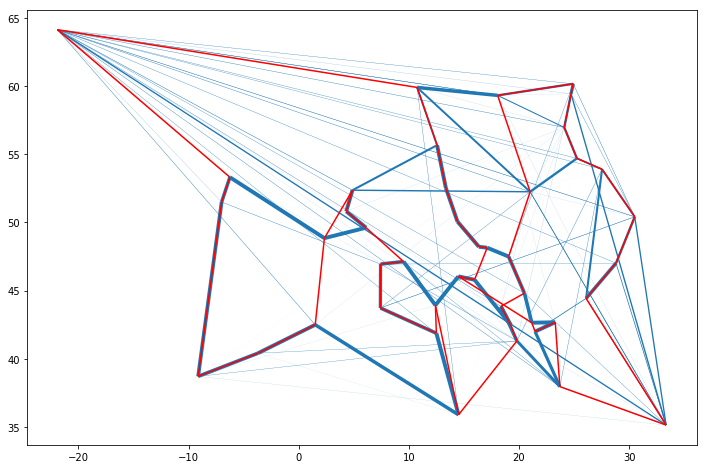

In [21]:
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
# solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

print('Fitness: ', fitness(vertices, distance, solution))

solution_vertices = [vertices[i] for i in solution]
pprint.pprint(solution_vertices)

solution_lines = []
for i, j in zip(solution, solution[1:]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])
solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])
solutions_lc = mc.LineCollection(solution_lines, colors='red')
ax.add_collection(solutions_lc)

Jen tak pro zajímavost rozhraní pro modelování různých přírodou inspirovaných systémů a algoritmů [NetLogo](http://ccl.northwestern.edu/netlogo/) poskytuje i simulaci mravenečků při hledání potravy. Podívat se na ně můžeme [zde](http://www.netlogoweb.org/launch#http://www.netlogoweb.org/assets/modelslib/Sample%20Models/Biology/Ants.nlogo).


## Úkol na cvičení

Poslední zmiňovaný algoritmus, který zde ale není naimplementovaný, je optimalizace pomocí včelí kolonie. Umělé včelí kolonie (ABC) je optimalizační algoritmus založený na chování včel při hledání potravy. Včely jsou rozděleny do třech skupin - na dělnice, vyčkávající včely a průzkumníky. Každá dělnice opracovává jeden zdroj jídla (a pozice těchto zdrojů kódují řešení). Při opracování dělnice navštíví zdroje jídla v okolí, a pokud je jiné řešení kvalitnější (má lepší fitness) nahradí svůj zdroj tímto novým zdrojem. Potom se všechny dělnice sejdou v úle, vymění si informace o kvalitě zdrojů a vyčkávající včely si vyberou některé z těchto zdrojů pomocí ruletové selekce. Dělnice si zároveň pamatují, jak dlouho už opracovávají daný zdroj, a pokud přesáhne tato doba nastavený limit, zdroj opustí a stanou se z nich průzkumníci. Průzkumníci prohledávají prostor náhodně a hledají nové zdroje potravy

Zkuste si tedy naimplementovat ve zbytku cvičení optimalizaci pomocí včelí kolonie a vyřešit s ní třeba problém rastrigin funkce, který je výše vyřešený pomocí optimalizace hejna částic.

## Domácí úkol

Za domácí úkol budete mít vyřešit pomocí optimalizace mravenčí kolonií [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem), což je vlastně jen zobecněný problém obchodního cestujícího na princip optimalizace rozvozu zásilek doručovací společnosti. Jedná se o to, že máme depa, každé má svá vlastní vozidla s danou kapacitou a nějakou množinu zásilek, které je potřeba rozvézt k jejich majitelům. Cílem je najít množinu doručovacích tras tak, aby byly všechny zásilky dodány majitelům a aby byly minimalizované celkové náklady, tedy aby byl použit co nejmenší počet vozidel a aby byly trasy co nejkratší.

V našem případě použijeme zjednodušenou verzi tohoto problému s jedním depem, které má neomezený počet vozidel jednoho typu. Vstupní data najdete ve složce *domaci_ukol_data*, jsou ve formátu xml a obsahují 3 soubory -- 2 malé a jeden větší, které zároveň obsahují:
- Seznam uzlů se souřadnicemi x a y, kdy uzel s typem 0 je depo, a ty ostatní s typem 1 jsou lokace zákazníků.
- Seznam vozidel, v tomto případě máme jeden typ vozidla, které musí začínat a končit v depu a má nějakou maximální kapacitu předmětů, které uveze.
- Seznam požadavků, neboli do jakého uzlu se toho má co dovézt.

Svůj kód, popis řešení, výsledky a jejich rozbor mi pošlete emailem do stanoveného deadline.